# import

In [1]:
import sys 
sys.path.append('C:\\Users\\Nuo.Chen\\PycharmProjects\\Imbalance_price_forecast')
from utils.import_packages import *
# from data_gathering.prepare_data import *

from xgboost import XGBClassifier, XGBRegressor
from models.evaluation import *

In [4]:
train_df = pd.read_excel(data_folder_path + '/train.xlsx')
test_df = pd.read_excel(data_folder_path + '/test.xlsx')

In [15]:
len(train_df)/(len(test_df)+len(train_df))

0.687903893951947

In [20]:
pos_train = train_df[train_df['DA>TAKE'] == 1]
neg_train = train_df[train_df['DA>TAKE'] == 0]
len(neg_train)/len(train_df)*100

34.40322774900638

In [10]:
pos_test = test_df[test_df['DA>TAKE'] == 1]
neg_test = test_df[test_df['DA>TAKE'] == 0]
len(neg_test)/len(test_df)*100

37.423679320414124

## cross validation

In [13]:
def cross_validation(target, model, feat_params, df, isRegression, n_folds=5, print_temp_info=True):
    results = defaultdict(list)
    ts_split = TimeSeriesSplit(n_splits=n_folds)
    feat_cols = None

    for fold, (train_index, test_index) in enumerate(ts_split.split(df), 1):
        start_time = time.time()
        print('Fold:{}'.format(fold))
        cv_train = df.iloc[train_index, :]
        cv_test = df.iloc[test_index, :]

        if isRegression:
            train_x, train_y = regression_feat_pipeline(feat_params, cv_train)
            test_x, test_y = regression_feat_pipeline(feat_params, cv_test)
            feat_cols = train_x.columns
            cv_model = model()
            cv_model.fit(train_x, train_y[target])

            train_pred = [round(p, 2) for p in cv_model.predict(train_x)]
            test_pred = [round(p, 2) for p in cv_model.predict(test_x)]

            train_metrics = Evaluator(train_pred, train_y[target]).regression_metrics()
            test_metrics = Evaluator(test_pred, test_y[target]).regression_metrics()
            results['test_WMAPE'].append(test_metrics['WMAPE'])
            results['models'].append(cv_model)

            if print_temp_info:
                print('train:')
                print(train_metrics)
                print('test:')
                print(test_metrics)
                print('takes:{} min\n'.format(round((time.time() - start_time) / 60, 2)))
        else:
            train_x, train_y = classification_feat_pipeline(feat_params, cv_train)
            test_x, test_y = classification_feat_pipeline(feat_params, cv_test)
            feat_cols = train_x.columns
            
            cv_model = model()
            cv_model.fit(train_x, train_y[target])
#             train_pred = cv_model.predict_proba(train_x)[:, 1]
#             test_pred = cv_model.predict_proba(test_x)[:, 1]
            train_pred = cv_model.predict(train_x)
            test_pred = cv_model.predict(test_x)

            train_metrics = Evaluator(train_pred, train_y[target]).classification_metrics()
            test_metrics = Evaluator(test_pred, test_y[target]).classification_metrics()
            results['auc'].append(test_metrics['AUC'])
            results['models'].append(cv_model)

            if print_temp_info:
                print('train:')
                print(train_metrics)
                print('test:')
                print(test_metrics)
                print('takes:{} min\n'.format(round((time.time() - start_time) / 60, 2)))

    return results, feat_cols


# train regression

train: 2016-01-01 - 2016-12-11

test: 2017-12-27 - 2018-6-1

train/test = 6.8:3.2

## feat pipeline

In [16]:
def regression_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price', 'DA-price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y                                                                        

In [17]:
lag_values = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
lag_dict = {'take_from_system_price':lag_values['yesterday'],\
           'feed_into_system_price':lag_values['yesterday'],\
           'DA-price':lag_values['around_time_before'],\
           'system_purchase_vol':lag_values['around_time_before'],\
           'system_sell_vol':lag_values['around_time_before'],\
           'system_absolute_vol':lag_values['around_time_before'],\
           'wind_value':lag_values['around_time_before']}

## train

In [18]:
# X, Y = regression_feat_pipeline(lag_dict, train_df)

In [19]:
out1,feat_cols = cross_validation('DA-price',XGBRegressor,\
                                  lag_dict,train_df, isRegression = True) 

Fold:1
train:
{'MPE': 23.0527, 'MAPE': 101.4811, 'WMAPE': 0.0058}
test:
{'MPE': 58.9808, 'MAPE': 153.1161, 'WMAPE': 0.0121}
takes:0.39 min

Fold:2
train:
{'MPE': 130.2737, 'MAPE': 294.6366, 'WMAPE': 0.0037}
test:
{'MPE': 48.5137, 'MAPE': 152.8672, 'WMAPE': 0.0135}
takes:0.5 min

Fold:3
train:
{'MPE': 32.1738, 'MAPE': 133.4395, 'WMAPE': 0.0027}
test:
{'MPE': 61.5493, 'MAPE': 176.9338, 'WMAPE': 0.0112}
takes:0.61 min

Fold:4
train:
{'MPE': 59.5314, 'MAPE': 160.6507, 'WMAPE': 0.0021}
test:
{'MPE': -1149.1965, 'MAPE': 1412.1242, 'WMAPE': 0.0108}
takes:0.72 min

Fold:5
train:
{'MPE': 31.8547, 'MAPE': 176.339, 'WMAPE': 0.0017}
test:
{'MPE': 83.3162, 'MAPE': 209.6825, 'WMAPE': 0.0143}
takes:0.83 min



## feat importance

In [21]:
model_error = out1['test_WMAPE']
best_model = out1['models'][model_error.index(min(model_error))]

plot_feature_importance(best_model, feat_cols)[-20:]

,importances,features
5,0.016012,wind_minvalue
332,0.018923,wind_value_192
2,0.018923,solar_minvalue
313,0.020378,DA-price_194
1,0.021834,solar_maxvalue
329,0.023290,wind_value_96
9,0.023290,cos_month
331,0.027656,wind_value_190
0,0.032023,solar_value
12,0.032023,sin_PTE


## test

In [22]:
test_x, test_y = regression_feat_pipeline(lag_dict, test_df)
test_true = test_y['take_from_system_price']
test_pred = best_model.predict(test_x)
test_pred = [round(p,2) for p in test_pred]

In [23]:
metrics = Evaluator(test_pred, test_true).regression_metrics()
metrics

{'MPE': 100.5337, 'MAPE': 101.5057, 'WMAPE': 0.0067}

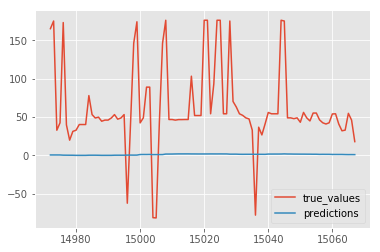

In [24]:
_ = plot_predictions( test_pred[-96:], test_true[-96:] )

In [25]:
save_result_to_file(data_folder_path+'/results/regression_wmape/', metrics['WMAPE'], lag_dict)

# DA > TAKE

## feat pipeline

In [26]:
lag_values2 = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
lag_dict2 = {'take_from_system_price':lag_values2['yesterday'],\
           'feed_into_system_price':lag_values2['yesterday'],\
           'DA-price':lag_values2['around_time_before'],\
           'system_purchase_vol':lag_values2['around_time_before'],\
           'system_sell_vol':lag_values2['around_time_before'],\
           'system_absolute_vol':lag_values2['around_time_before'],\
           'wind_value':lag_values2['around_time_before']}

In [27]:
def classification_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y

## train

In [28]:
out2,feat_cols2 = cross_validation('DA>TAKE',XGBClassifier,\
                                  lag_dict2,train_df, isRegression = False,\
                                   n_folds = 5) 

Fold:1
train:
{'AUC': '0.7586', 'Accuracy': 80.4978}
test:
{'AUC': '0.6002', 'Accuracy': 67.299}
takes:0.4 min

Fold:2
train:
{'AUC': '0.6845', 'Accuracy': 75.8217}
test:
{'AUC': '0.6096', 'Accuracy': 67.4593}
takes:0.5 min

Fold:3
train:
{'AUC': '0.6752', 'Accuracy': 73.7863}
test:
{'AUC': '0.6188', 'Accuracy': 69.2941}
takes:0.63 min

Fold:4
train:
{'AUC': '0.6655', 'Accuracy': 72.9287}
test:
{'AUC': '0.5987', 'Accuracy': 72.6081}
takes:0.71 min

Fold:5
train:
{'AUC': '0.6486', 'Accuracy': 72.7809}
test:
{'AUC': '0.5590', 'Accuracy': 69.4966}
takes:0.85 min



## feat importance

In [29]:
model_auc = out2['auc']
best_model2 = out2['models'][model_auc.index(max(model_auc))]

plot_feature_importance(best_model2, feat_cols2)[-10:]

,importances,features
317,0.022124,system_purchase_vol_192
322,0.023599,system_sell_vol_192
13,0.023599,cos_PTE
319,0.025074,system_sell_vol_96
2,0.026549,solar_minvalue
309,0.029499,DA-price_96
12,0.030973,sin_PTE
20,0.035398,weekday_6
11,0.035398,cos_day
117,0.044248,take_from_system_price_96


## test

In [ ]:
cross_validation( train_df, 'DA>TAKE', XGBClassifier, make_feat_pipeline, lag_dict)
cross_validation(df, targetName, model, make_feat, feat_params, n_folds=5, classification = True, print_temp_info=True):

In [30]:
test_x, test_y = classification_feat_pipeline(lag_dict2, test_df)
test_y = test_y['DA>TAKE']
test_proba = best_model2.predict_proba(test_x)[:,1]
test_pred = best_model2.predict(test_x)

metrics2 = Evaluator(test_pred, test_y).classification_metrics()
metrics2

{'AUC': '0.5920', 'Accuracy': 66.817}

In [32]:
np.sum(test_y)/len(test_y)*100

62.43521572322811

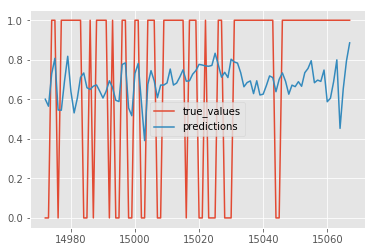

In [33]:
_ = plot_predictions( test_proba[-96:], test_y[-96:] )

In [34]:
save_result_to_file(data_folder_path+'/results/classification_acc/', metrics2['Accuracy'], lag_dict)